## SVM projection of microglia from Bian et al., 2020 on our gonadal immune cells

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

#### Load data

In [2]:
path_to_bian = '/nfs/team292/vl6/Microglia/'
path_to_atlas = '/nfs/team292/vl6/immune_fetal_gonads/'

In [3]:
bian = sc.read(path_to_bian + 'Paper_microglia.h5ad')
bian = anndata.AnnData(X = bian.raw.X, var = bian.raw.var, obs = bian.obs)
bian.shape

(1231, 18917)

In [4]:
atlas = sc.read(path_to_atlas + 'immune_merged_lineages_annotated.h5ad')
atlas.shape

(19538, 20675)

In [5]:
atlas = anndata.AnnData(X = atlas.raw.X, var = atlas.raw.var, obs = atlas.obs)
atlas.shape

(19538, 28497)

#### Intersect genes

In [6]:
bian_genes = bian.var_names.to_list()
atlas_genes = atlas.var_names.to_list()

from functools import reduce
inters = reduce(np.intersect1d, (bian_genes, atlas_genes))
len(inters)

16280

In [7]:
bian = bian[:, list(inters)]
bian

/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 1231 × 16280
    obs: 'tissue', 'paper_annotation', 'stage', 'individual', 'paper_cluster', 'n_genes', 'n_counts', 'sample'
    var: 'n_cells'

#### Process the data

In [8]:
# Per cell normalization
sc.pp.normalize_per_cell(bian, counts_per_cell_after=1e4)
# Log transformation 
sc.pp.log1p(bian)

Trying to set attribute `.obs` of view, copying.


In [9]:
# Filter HVGs --> Select top 200 highly variable genes that will serve as features to the machine learning models  
sc.pp.highly_variable_genes(bian, n_top_genes = 200)
highly_variable_genes = bian.var["highly_variable"]
bian = bian[:, highly_variable_genes]

/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
# Scale
sc.pp.scale(bian, max_value=10)
print('Total number of cells: {:d}'.format(bian.n_obs))
print('Total number of genes: {:d}'.format(bian.n_vars))

Total number of cells: 1231
Total number of genes: 200


/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### Train SVM model

In [11]:
# Required libraries regardless of the model you choose
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Library for Logistic Regression
from sklearn.linear_model import LogisticRegression

# Library for Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Library for Support Vector Machine 
from sklearn.svm import SVC

In [12]:
print("Loading data")
X = np.array(bian.X) # Fetching the count matrix to use as input to the model 
print(type(X), X.shape)

Loading data
<class 'numpy.ndarray'> (1231, 200)


In [13]:
# Choose output variable, meaning the labels you want to predict 
y = list(bian.obs.paper_cluster.astype('str'))

In [14]:
# Split the training dataset into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3, # This can be changed, though it makes sense to use 25-30% of the data for test
        random_state=1234,
    )

In [15]:
# Instantiate an RBF Support Vector Machine
svm = SVC(kernel = "rbf", probability = True)

# Instantiate a PCA 
pca = PCA()

# Create pipeline object
pipe = Pipeline(steps=[('pca', pca), ('SVC', svm)])

print('Hyperparameter tuning with exhaustive grid search')

# Choose a grid of hyperparameters values (these are arbitrary but reasonable as I took reference values from the documentation)
params_svm = {'SVC__C':[0.1, 1, 10, 100], 'SVC__gamma':[0.001, 0.01, 0.1], 'pca__n_components': [0.7, 0.8, 0.9]}

# Use grid search cross validation to span the hyperparameter space and choose the best 
grid_svm = GridSearchCV(pipe, params_svm, cv=5, verbose =1, n_jobs = -1)

# Fit the model to the training set of the training data
grid_svm.fit(X_train, y_train)

# Report the best hyperparameters and the corresponding score
print("Best CV params", grid_svm.best_params_)
print("Best CV accuracy", grid_svm.best_score_)

Hyperparameter tuning with exhaustive grid search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV params {'SVC__C': 10, 'SVC__gamma': 0.001, 'pca__n_components': 0.9}
Best CV accuracy 0.8420688264551688


In [16]:
predicted_labels = grid_svm.best_estimator_.predict(X_test) # Here as an example I am using the support vector machine model
report_rf = classification_report(y_test, predicted_labels)
print(report_rf)
print("Accuracy:", accuracy_score(y_test, predicted_labels))

              precision    recall  f1-score   support

         EMP       0.78      0.86      0.82        29
         ErP       0.88      0.88      0.88        24
         GMP       1.00      0.80      0.89        15
        HSPC       1.00      0.67      0.80         9
         ILC       1.00      0.80      0.89         5
         LMP       0.64      0.85      0.73        34
 Lymphoblast       0.86      0.78      0.82        41
       Mac_1       0.86      0.90      0.88        21
       Mac_2       0.83      0.89      0.86        66
       Mac_3       0.82      0.60      0.69        15
       Mac_4       0.96      0.96      0.96        28
   Mast cell       0.86      1.00      0.92         6
         MkP       0.80      1.00      0.89         8
    Monocyte       0.76      0.61      0.68        41
  Myeloblast       0.96      0.96      0.96        28

    accuracy                           0.84       370
   macro avg       0.87      0.84      0.85       370
weighted avg       0.84   

Text(0.5, 266.08, 'Predicted label')

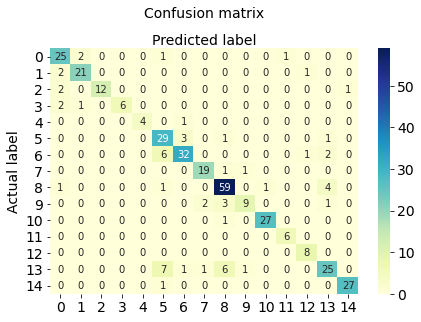

In [17]:
cnf_matrix = confusion_matrix(y_test, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [18]:
print("Accuracy:", accuracy_score(y_test, predicted_labels))

Accuracy: 0.8351351351351352


In [19]:
grid_svm.best_estimator_.feature_names = list(bian.var_names)

In [20]:
def process_and_subset_data(adata, genes):
    # save the log transformed counts as raw 
    adata.raw = adata.copy()
    # Per cell normalization
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    # Log transformation 
    sc.pp.log1p(adata)
    # Subset data
    adata = adata[:, list(genes)]
    # Scale
    sc.pp.scale(adata, max_value=10)
    return adata

In [21]:
def process_data(adata):
    # Per cell normalization
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    # Log transformation 
    sc.pp.log1p(adata)
    # Scale
    sc.pp.scale(adata, max_value=10)

In [22]:
import scipy
def make_single_predictions(adata, classifier): 
    #if scipy.sparse.issparse(adata.X):
        #adata.X = adata.X.toarray()
    adata_X = np.array(adata.X)
    print(type(adata_X), adata_X.shape)
    adata_preds = classifier.predict(adata_X)
    adata.obs['human_classifier_supporting'] = adata_preds
    print(adata.obs.human_classifier_supporting.value_counts(dropna = False))

In [23]:
def make_correspondence(classifier):
    corr = {}
    for i in range(0,len(classifier.classes_)):
            corr[i] = classifier.classes_[i]
    return corr

In [24]:
def make_probability_predictions(adata, classifier):
    adata_X = np.array(adata.X)
    print(type(adata_X), adata_X.shape)
    proba_preds = classifier.predict_proba(adata_X)
    df_probs = pd.DataFrame(np.column_stack(list(zip(*proba_preds))))
    corr = make_correspondence(classifier)
    for index in df_probs.columns.values:
        celltype = corr[index]
        adata.obs['prob_'+celltype] = df_probs[index].to_list()

In [25]:
atlas = process_and_subset_data(atlas, grid_svm.best_estimator_.feature_names)
make_single_predictions(atlas, grid_svm.best_estimator_)

/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


<class 'numpy.ndarray'> (19538, 200)
Mac_2          6265
Myeloblast     2504
Monocyte       2084
LMP            1824
EMP            1695
Lymphoblast    1504
ILC            1241
Mac_4           579
Mac_3           426
Mac_1           321
GMP             314
Mast cell       260
MkP             234
ErP             218
HSPC             69
Name: human_classifier_supporting, dtype: int64


In [26]:
make_probability_predictions(atlas, grid_svm.best_estimator_)

<class 'numpy.ndarray'> (19538, 200)


In [27]:
atlas.obs[['prob_EMP', 'prob_ErP', 'prob_GMP', 'prob_HSPC', 'prob_ILC', 'prob_LMP', 
           'prob_Lymphoblast', 'prob_Mac_1', 'prob_Mac_2', 'prob_Mac_3',
           'prob_Mac_4', 'prob_MkP', 'prob_Myeloblast']].to_csv(path_to_atlas + "_SVM_predictions_Bian.csv")

#### End of notebook